In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
import itertools
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neighbors import KNeighborsRegressor
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras.models import load_model
from numpy.random import seed
from statsmodels.stats.multitest import multipletests
from scipy.stats import ranksums
from more_itertools import powerset
from numpy import cov

%matplotlib inline
%config InlineBackend.figure_format = 'svg'    

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

sns.set()
warnings.filterwarnings('ignore')
random_seed = 10000
seed(random_seed)

In [4]:
df = pd.read_csv('winequality.csv')
y_label = 'quality'
df = df._get_numeric_data()
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


## Correlation to Sale-Price

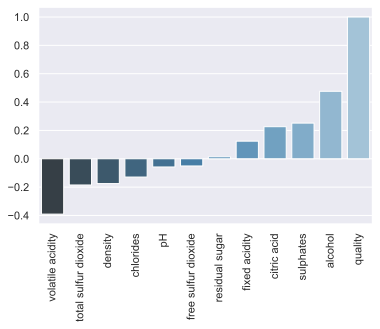

In [5]:
correlation = df.corr()[y_label].sort_values()
dd = pd.DataFrame(correlation)
chart = sns.barplot(correlation.index, correlation.values, palette="Blues_d")

_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [12]:
top_8_cats = abs(df.corr())[y_label].sort_values(ascending=False)
top_8_cats = top_8_cats.drop(['quality', 'pH', 'free sulfur dioxide', 'residual sugar'])
for i, cat in enumerate(top_8_cats.index):
    print(str(i + 1) + ") " + cat)
data = df[list(top_8_cats.index) + [y_label]]

1) alcohol
2) volatile acidity
3) sulphates
4) citric acid
5) total sulfur dioxide
6) density
7) chlorides
8) fixed acidity


## Visualization

In [13]:
_ = sns.pairplot(data=data, y_vars=[y_label], x_vars=data.columns, kind="reg", diag_kind="kde", plot_kws={'line_kws':{'color':'purple'}, 'scatter_kws': {'alpha': 0.2}})

# Correlation Heatmap

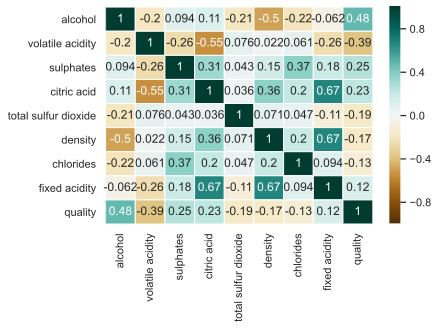

In [14]:
_ = sns.heatmap(data.corr(), cmap="BrBG", linewidths = 1, vmin = -1, vmax = 1, annot = True)

In [15]:
corr = data.corr().values

# Neural Network Training

In [16]:
test_precent = 0.2
train_precent = 1.0 - test_precent
train_data = data.sample(frac=train_precent, random_state=random_seed)
test_data = data.drop(train_data.index)

In [17]:
train_stats = train_data.describe().T
def normalize(x):
    result = x.copy()
    for feature_name in x.columns:
        average = x[feature_name].mean()
        std = x[feature_name].std()
        result[feature_name] = (x[feature_name] - average) / std
    return result
normalized_train_data = normalize(train_data)
normalized_test_data = normalize(test_data)
normalized_train_data.head()

,alcohol,volatile acidity,sulphates,citric acid,total sulfur dioxide,density,chlorides,fixed acidity,quality
1222,-0.765381,0.001042,-1.155690,-0.258383,1.264177,0.025000,-0.205047,-0.123044,0.458744
770,-0.670752,0.327522,-0.745066,-1.300551,1.413905,0.373818,-0.115118,-0.705262,0.458744
1286,1.884233,-2.012250,-0.686406,0.888002,-0.472668,-1.824794,-0.429869,-0.705262,0.458744
886,-0.008348,1.470202,-0.041140,-0.779467,-0.562504,0.860050,-0.092636,0.400952,0.458744
530,-0.102977,-1.685770,1.249391,-0.154166,-0.562504,1.198298,-0.205047,0.459173,0.458744


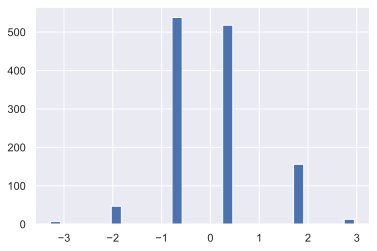

In [18]:
_ = plt.hist(normalized_train_data[y_label], bins = 30)

In [19]:
train_x = normalized_train_data.drop(y_label, axis = 1)
train_y = normalized_train_data[y_label]
test_x = normalized_test_data.drop(y_label, axis = 1)
test_y = normalized_test_data[y_label]

In [20]:
def build_fully_NN_model(train):
    input_layer    = Input(shape=(train.shape[1],))
    hidden_layer_1 = Dense(10, activation=tf.nn.relu)(input_layer)
    hidden_layer_2 = Dense(10, activation=tf.nn.relu)(hidden_layer_1)
    output_layer   = Dense(1)(hidden_layer_2)
   
    model = Model(input=[input_layer], output=[output_layer])
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    
    return model

In [21]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def train_model(model, X, Y, show_dots = True):
    mc = ModelCheckpoint('best_nn_model.nn', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)
    callbacks=[mc, es]
    if show_dots:
        callbacks.append(PrintDot())
    history = model.fit(X, Y, epochs=200, validation_split = 0.33, verbose=0, callbacks=callbacks)
    model = load_model('best_nn_model.nn')
    return history, model

In [22]:
runs_amount = 5
runs = dict()
all_features_label = 'all features'
runs[all_features_label] = []
for i in range(runs_amount):
    fully_NN_model = build_fully_NN_model(train_x)
    fully_NN_history, fully_NN_model = train_model(fully_NN_model, train_x, train_y, False)
    loss, mse = fully_NN_model.evaluate(test_x, test_y, verbose=0)
    runs[all_features_label].append(mse)
    print('.', end='')
    
runs[all_features_label].append(0.0)
runs[all_features_label].append(0.0)
runs[all_features_label].append(0.0)
runs[all_features_label].append(0.0)

.....

In [23]:
def build_halved_model(group1, group2, group3, group4):
    input1 = Input(shape=(len(group1),))
    hidden1_1 = Dense(4, activation='relu')(input1)
    hidden1_2 = Dense(4, activation='relu')(hidden1_1)
    out1 = Dense(1)(hidden1_2)
    
    input2 = Input(shape=(len(group2),))
    hidden2_1 = Dense(4, activation='relu')(input2)
    hidden2_2 = Dense(4, activation='relu')(hidden2_1)
    out2 = Dense(1)(hidden2_2)
    
    input3 = Input(shape=(len(group3),))
    hidden3_1 = Dense(4, activation='relu')(input3)
    hidden3_2 = Dense(4, activation='relu')(hidden3_1)
    out3 = Dense(1)(hidden3_2)
    
    input4 = Input(shape=(len(group4),))
    hidden4_1 = Dense(4, activation='relu')(input4)
    hidden4_2 = Dense(4, activation='relu')(hidden4_1)
    out4 = Dense(1)(hidden4_2)
    
    merge = concatenate([out1, out2, out3, out4], name='merge')
    #hidden = Dense(4, activation='relu')(merge)
    #hidden_x = Dense(4)(hidden)
    output = Dense(1)(merge)
    
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    
    return model
def calc_halved_NN_mse(g1, g2, g3, g4):
    halved_train_X = [train_x[g1], train_x[g2], train_x[g3], train_x[g4]]
    halved_train_Y = train_y
    halved_test_X = [test_x[g1], test_x[g2], test_x[g3], test_x[g4]]
    halved_test_Y = test_y
    name = (str(g1), str(g2), str(g3), str(g4))
    runs[name] = []
    for i in range(runs_amount):
        halved_model = build_halved_model(g1, g2, g3, g4)
        _, halved_model = train_model(halved_model, halved_train_X, halved_train_Y, False)
        _, mse = halved_model.evaluate(halved_test_X, halved_test_Y, verbose=0)
        runs[name].append(mse)
    return name

In [24]:
iteration = 0

def is_lower(g1, g2):
    val1 = g1[0] * 8 + g1[1]
    val2 = g2[0] * 8 + g2[1]
    return val1 < val2

def is_unique(g1, g2, g3, g4):
    vals = g1 + g2 + g3 + g4
    return len(vals) == len(set(vals))

def all_2_2_2_2():
    all_combinations = list(itertools.combinations(list(range(8)), 2))
    combinations = []
    all_options = []
    for g1 in all_combinations:
        for g2 in all_combinations:
            if is_lower(g1, g2):
                for g3 in all_combinations:
                    if is_lower(g2, g3):
                        for g4 in all_combinations:
                            if is_lower(g3, g4):
                                if is_unique(g1, g2, g3, g4):
                                    combinations.append((g1, g2, g3, g4))
    return combinations

def get_corr(subset):
    return corr[subset[0], subset[1]]
for subset1, subset2, subset3, subset4 in all_2_2_2_2():
    g1 = [top_8_cats.index[i] for i in subset1]
    g2 = [top_8_cats.index[i] for i in subset2]
    g3 = [top_8_cats.index[i] for i in subset3]
    g4 = [top_8_cats.index[i] for i in subset4]
    
    #for __ in range(runs_amount):
    name = calc_halved_NN_mse(g1, g2, g3, g4)

    runs[name].append(get_corr(subset1))
    runs[name].append(get_corr(subset2))
    runs[name].append(get_corr(subset3))
    runs[name].append(get_corr(subset4))
    print('.', end= '')
    iteration += 1
    pd.DataFrame(runs).transpose().to_csv('NN_test_set_prediction_results' + str(iteration) + '.csv')

#scores = [calc_halved_NN_mse(group1, group2) for (group1, group2) in groups]
#merged_parametric_rank_sum['Halved_NN_MSE'] = scores

.........................................................................................................

In [47]:
pd.DataFrame(runs).transpose().to_csv('NN_test_set_prediction_results.csv')